<a href="https://colab.research.google.com/github/banatehrani/TensorFlow-and-Neural-Networks/blob/main/TensorFlow_and_Transfer_Learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal is to beat the food 101 paper perfromance (50.76%) using only 10% of the training data.

In [ ]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-25 18:37:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-25 18:37:18 (96.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [ ]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-01-25 18:37:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.214.128, 74.125.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   144MB/s    in 11s     

2023-01-25 18:37:35 (142 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_quesadilla'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chocolate_mousse'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/carrot_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/prime_rib'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/mussels'.
There are 0 directo

In [ ]:
# Setup data inputs
import tensorflow as tf
IMAGE_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMAGE_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# Create checkpoint callback to save model for later use, could be in the helper function
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [ ]:
# Import the required modules for model creation 
# You could put this in the helper function as well
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge, if you comment this one the model will work better.
    preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
    preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
    preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
    preprocessing.RandomZoom(0.2), # randomly zoom into an image
    # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [ ]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)  # We have 101 classes not 1000 in the output layer
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - 96s 347ms/step - loss: 3.3806 - accuracy: 0.2700 - val_loss: 2.5228 - val_accuracy: 0.4454
Epoch 2/5
237/237 [==============================] - 65s 272ms/step - loss: 2.2019 - accuracy: 0.4940 - val_loss: 2.0823 - val_accuracy: 0.5040
Epoch 3/5
237/237 [==============================] - 59s 246ms/step - loss: 1.8218 - accuracy: 0.5633 - val_loss: 1.9004 - val_accuracy: 0.5270
Epoch 4/5
237/237 [==============================] - 56s 234ms/step - loss: 1.6069 - accuracy: 0.6143 - val_loss: 1.8473 - val_accuracy: 0.5260
Epoch 5/5
237/237 [==============================] - 53s 224ms/step - loss: 1.4336 - accuracy: 0.6511 - val_loss: 1.7836 - val_accuracy: 0.5368


In [ ]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 58s 73ms/step - loss: 1.5812 - accuracy: 0.5876


[1.5811764001846313, 0.587643563747406]

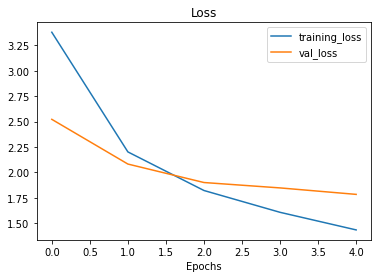

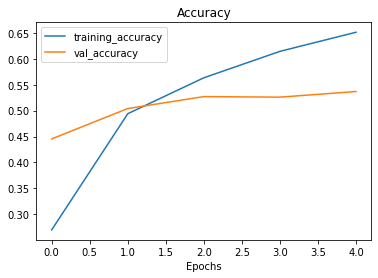

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [ ]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 60s 223ms/step - loss: 1.2278 - accuracy: 0.6751 - val_loss: 1.7569 - val_accuracy: 0.5381
Epoch 6/10
237/237 [==============================] - 48s 200ms/step - loss: 1.0825 - accuracy: 0.7085 - val_loss: 1.7326 - val_accuracy: 0.5448
Epoch 7/10
237/237 [==============================] - 49s 207ms/step - loss: 1.0149 - accuracy: 0.7298 - val_loss: 1.6944 - val_accuracy: 0.5556
Epoch 8/10
237/237 [==============================] - 47s 196ms/step - loss: 0.9365 - accuracy: 0.7516 - val_loss: 1.7497 - val_accuracy: 0.5432
Epoch 9/10
237/237 [==============================] - 46s 191ms/step - loss: 0.8991 - accuracy: 0.7560 - val_loss: 1.7307 - val_accuracy: 0.5469
Epoch 10/10
237/237 [==============================] - 44s 183ms/step - loss: 0.8108 - accuracy: 0.7819 - val_loss: 1.7051 - val_accuracy: 0.5543


In [ ]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 57s 72ms/step - loss: 1.4959 - accuracy: 0.6049


[1.4958782196044922, 0.6049109101295471]

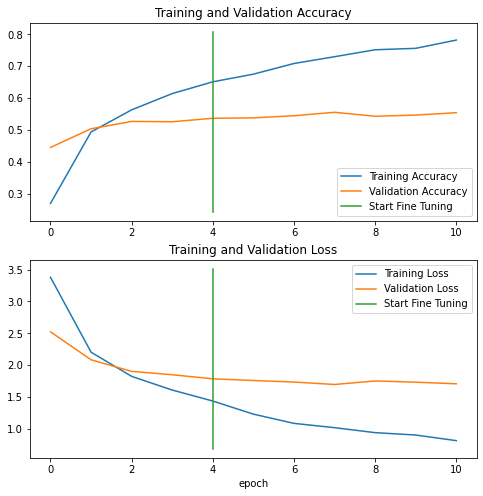

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [ ]:
# Save model to drive so it can be used later 
model.save("/content/drive/MyDrive/ZTM - TensorFlow Developer Certificate in 2023")

In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/ZTM - TensorFlow Developer Certificate in 2023")

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 59s 72ms/step - loss: 1.4959 - accuracy: 0.6049


[1.4958782196044922, 0.6049109101295471]

In [ ]:
results_all_classes_10_percent_fine_tune

[1.4958782196044922, 0.6049109101295471]

In [ ]:
#****** Test data must be in the same shape/size of the data used for training, 224,224,...

# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

790/790 [==============================] - 62s 77ms/step


In [ ]:
len(pred_probs)

25250

In [ ]:
pred_probs.shape

(25250, 101)

In [ ]:
pred_probs[0].shape

(101,)

In [ ]:
pred_probs

array([[3.1682193e-01, 2.3871109e-04, 1.8993269e-01, ..., 1.1834637e-05,
        3.9253216e-03, 1.9907774e-02],
       [8.1979853e-01, 1.7830926e-08, 5.4279057e-04, ..., 2.2979858e-03,
        8.0557406e-08, 4.9689606e-06],
       [5.6479532e-01, 8.1643313e-03, 1.6595766e-02, ..., 3.1922333e-04,
        1.8427595e-04, 2.0281659e-03],
       ...,
       [4.4465636e-05, 2.7622119e-02, 1.0719413e-06, ..., 1.6747271e-03,
        2.8057277e-04, 5.8398002e-01],
       [2.9700033e-03, 4.2416573e-02, 1.7981756e-02, ..., 8.6205237e-04,
        4.0880824e-04, 1.9578411e-01],
       [1.6303638e-01, 2.1043420e-03, 6.1088125e-03, ..., 2.1856916e-03,
        5.0149806e-04, 4.2181310e-01]], dtype=float32)

In [ ]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [3.16821933e-01 2.38711087e-04 1.89932689e-01 7.72518192e-08
 1.31275119e-05 1.10556925e-06 1.12495545e-04 1.13779170e-05
 1.76481120e-02 3.21248110e-04 3.66407960e-07 2.77029721e-06
 8.91388918e-04 3.47693714e-07 7.30489707e-03 1.10441225e-03
 2.19264894e-05 9.22214938e-04 5.65352477e-03 1.57941122e-05
 7.09429849e-04 4.55857935e-06 1.42140445e-04 3.73128751e-05
 1.47754827e-03 2.80938903e-03 2.00235122e-03 6.71853995e-05
 7.76224881e-02 7.77417910e-04 2.07235325e-06 1.60478009e-03
 5.13705658e-04 5.13980524e-07 1.39141772e-02 3.43022998e-06
 3.08611488e-05 1.48643681e-03 2.75024250e-02 8.39409913e-05
 1.46161838e-04 2.30875518e-03 8.33922022e-05 3.06428205e-06
 1.22303187e-04 1.10965339e-05 2.90097203e-03 1.12441267e-04
 1.20785262e-06 6.92354590e-02 3.95188312e-04 2.25848726e-05
 9.60680097e-02 1.00781433e-02 1.37632387e-05 3.61280120e-03
 2.39243824e-02 1.70401298e-03 2.39921268e-

In [ ]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0, 38,  8, 78, 29, 46,  0,  0])

In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
    y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6049108910891089

In [ ]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
import numpy as np
print(f"Close? {np.isclose(loaded_model_results[1], sklearn_accuracy)} | Difference: {loaded_model_results[1] - sklearn_accuracy}")

Close? True | Difference: 1.904043822609225e-08


In [ ]:
# We'll import our make_confusion_matrix function from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py 
# But if you run it out of the box, it doesn't really work for 101 classes...
# the cell below adds a little functionality to make it readable.
from helper_functions import make_confusion_matrix

In [ ]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# Get the class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

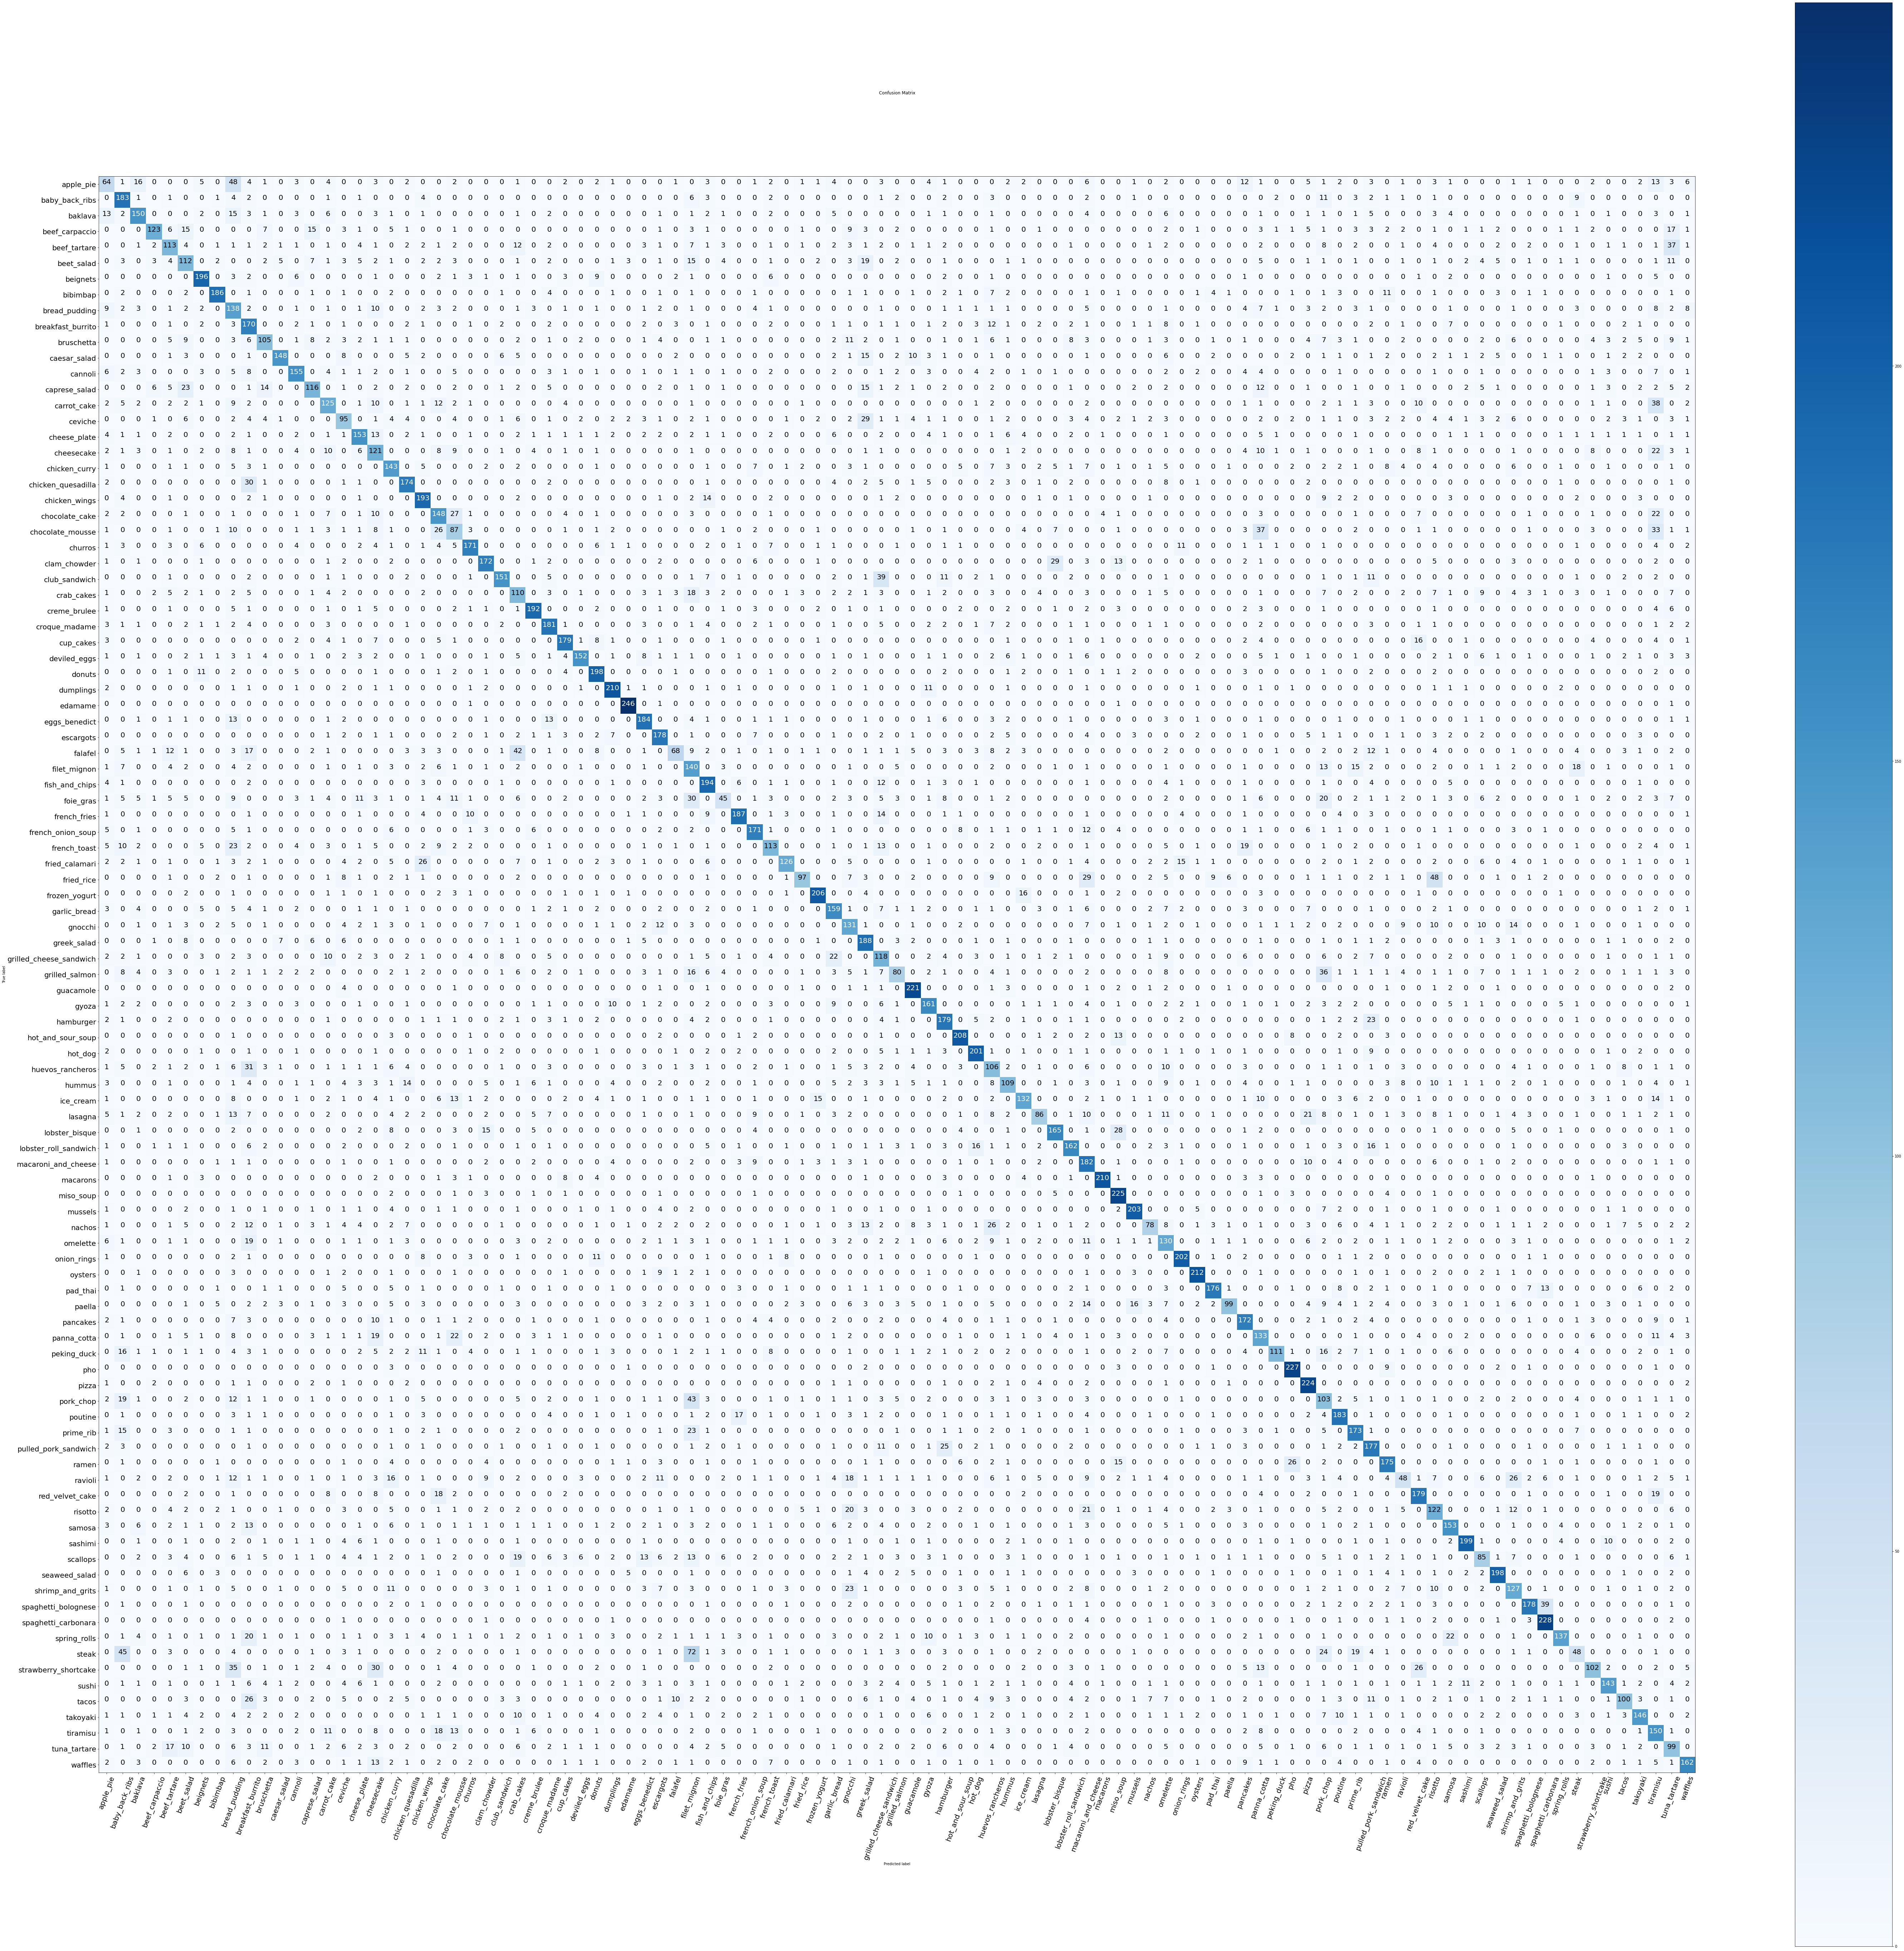

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.34      0.26      0.29       250
           1       0.49      0.73      0.59       250
           2       0.65      0.60      0.62       250
           3       0.83      0.49      0.62       250
           4       0.48      0.45      0.47       250
           5       0.42      0.45      0.44       250
           6       0.75      0.78      0.77       250
           7       0.86      0.74      0.80       250
           8       0.27      0.55      0.36       250
           9       0.37      0.68      0.48       250
          10       0.55      0.42      0.48       250
          11       0.85      0.59      0.70       250
          12       0.70      0.62      0.66       250
          13       0.63      0.46      0.54       250
          14       0.53      0.50      0.51       250
          15       0.42      0.38      0.40       250
          16       0.62      0.61      0.62       250
          17       0.36    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3386243386243386,
  'recall': 0.256,
  'f1-score': 0.29157175398633256,
  'support': 250},
 '1': {'precision': 0.4945945945945946,
  'recall': 0.732,
  'f1-score': 0.5903225806451612,
  'support': 250},
 '2': {'precision': 0.646551724137931,
  'recall': 0.6,
  'f1-score': 0.6224066390041493,
  'support': 250},
 '3': {'precision': 0.825503355704698,
  'recall': 0.492,
  'f1-score': 0.6165413533834586,
  'support': 250},
 '4': {'precision': 0.48497854077253216,
  'recall': 0.452,
  'f1-score': 0.46790890269151136,
  'support': 250},
 '5': {'precision': 0.42424242424242425,
  'recall': 0.448,
  'f1-score': 0.4357976653696498,
  'support': 250},
 '6': {'precision': 0.7509578544061303,
  'recall': 0.784,
  'f1-score': 0.767123287671233,
  'support': 250},
 '7': {'precision': 0.8611111111111112,
  'recall': 0.744,
  'f1-score': 0.7982832618025751,
  'support': 250},
 '8': {'precision': 0.26848249027237353,
  'recall': 0.552,
  'f1-score': 0.36125654450261785,
  'support

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
    if k == "accuracy": # stop once we get to accuracy key
        break
    else:
        # Append class names and f1-scores to new dictionary
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.29157175398633256,
 'baby_back_ribs': 0.5903225806451612,
 'baklava': 0.6224066390041493,
 'beef_carpaccio': 0.6165413533834586,
 'beef_tartare': 0.46790890269151136,
 'beet_salad': 0.4357976653696498,
 'beignets': 0.767123287671233,
 'bibimbap': 0.7982832618025751,
 'bread_pudding': 0.36125654450261785,
 'breakfast_burrito': 0.4761904761904762,
 'bruschetta': 0.4772727272727273,
 'caesar_salad': 0.6981132075471698,
 'cannoli': 0.6567796610169492,
 'caprese_salad': 0.535796766743649,
 'carrot_cake': 0.5133470225872689,
 'ceviche': 0.3991596638655462,
 'cheese_plate': 0.6181818181818182,
 'cheesecake': 0.41296928327645044,
 'chicken_curry': 0.5276752767527675,
 'chicken_quesadilla': 0.6904761904761905,
 'chicken_wings': 0.6892857142857143,
 'chocolate_cake': 0.5421245421245421,
 'chocolate_mousse': 0.34730538922155685,
 'churros': 0.7261146496815287,
 'clam_chowder': 0.6963562753036437,
 'club_sandwich': 0.6879271070615034,
 'crab_cakes': 0.40590405904059046,
 'creme_bru

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

class_name  f1-score
33        edamame  0.955340
63       macarons  0.893617
69        oysters  0.861789
75            pho  0.854991
45  frozen_yogurt  0.837398
..            ...       ...
77      pork_chop  0.336601
0       apple_pie  0.291572
39      foie_gras  0.265487
82        ravioli  0.258760
93          steak  0.254642

[101 rows x 2 columns]

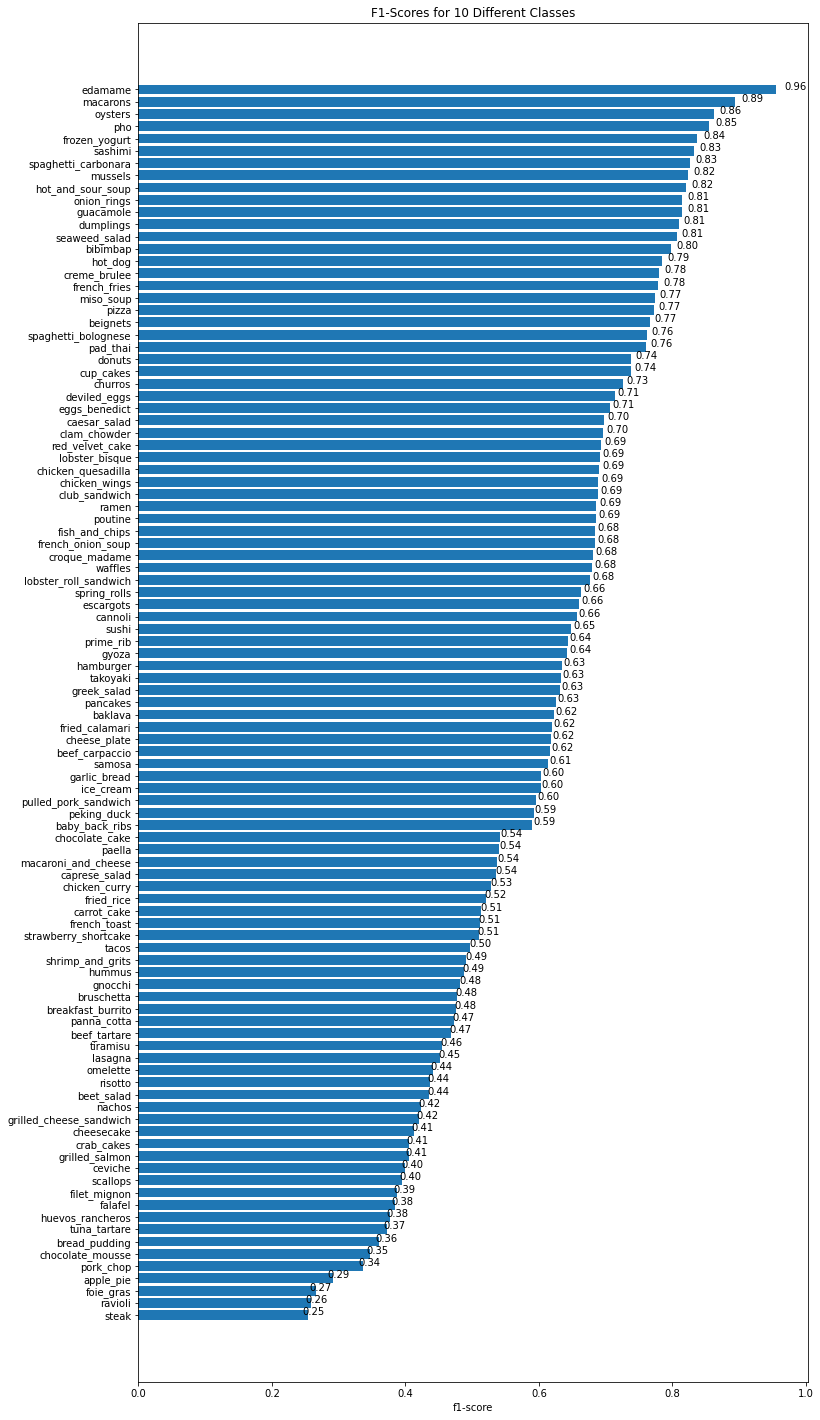

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
    """
    Attach a text label above each bar displaying its height (it's value).
    """
    for rect in rects:
        width = rect.get_width()
        ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
                f"{width:.2f}",
                ha='center', va='bottom')

autolabel(scores)

 **Testing on custom images outside of the test set**

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).

    Parameters
    ----------
    filename (str): string filename of target image
    img_shape (int): size to resize target image to, default 224
    scale (bool): whether to scale pixel values to range(0, 1), default True
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.io.decode_image(img)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        # Rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img # Don't need to rescale for EfficientNet models in TensorFlow

1/1 [==============================] - 0s 22ms/step


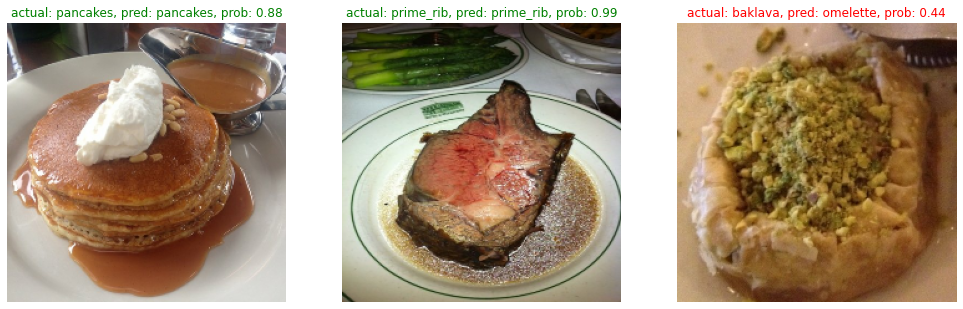

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
    # Choose a random image from a random class 
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + class_name + "/" + filename

    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
    pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
    pred_class = class_names[pred_prob.argmax()] # find the predicted class 

    # Plot the image(s)
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);

In [ ]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False): # When created the test data we didn't shuffle it
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      38   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.316822        apple_pie        apple_pie  
1   0.819799        apple_pie        apple_pie  
2   0.564795        apple_pie        apple_pie  
3   0.339237        apple_pie   fish_and_chips  
4   0.530199        apple_pie    bread_pudding

In [ ]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      38   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.316822        apple_pie        apple_pie          True  
1   0.819799        apple_pie        apple_pie          True  
2   0.564795        apple_pie        apple_pie          True  
3   0.339237        apple_pie   fish_and_chips         False  
4   0.530199        apple_pie    bread_pudding         False

In [ ]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
191    b'101_food_classes_10_percent/test/apple_pie/3...       0      31   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
14691  b'101_food_classes_10_percent/test/ice_cream/3...      58      79   
5849   b'101_food_classes_10_percent/test/churros/254...      23      68   
15142  b'101_food_classes_10_percent/test/lobster_bis...      60      64   
5114   b'101_food_classes_10_percent/test/chicken_win...      20      38   
3031   b'101_food_classes_10_percent/test/cannoli/134...      12      98   
11146  b'101_food_classes_10_percent/test/fried_rice/...      44      62   
19430  b'101_food_classes_10_percent/test/pork_chop/3...      77       1   
7295   b'101_food_classes_10_percent/test/cup_cakes/1...      29      31   
18935  b'101_food_classes_10_percent/test/pho/3741977...      75      33   
12487  b'101_food_classes_10_percent/test/grilled_che...      49      25   
6108   b'101_food_classes_10_percent/test/clam_chowde...      24      27   
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
15826  b'101_food_classes_10_percent/test/macarons/19...      63      29   
9326   b'101_food_classes_10_percent/test/filet_migno...      37      79   

       pred_conf         y_true_classname     y_pred_classname  pred_correct  
23797   0.998630                    sushi              sashimi         False  
11642   0.998452             garlic_bread           bruschetta         False  
191     0.998137                apple_pie               donuts         False  
18001   0.997592                 pancakes             omelette         False  
17855   0.996459                   paella              mussels         False  
10847   0.996288           fried_calamari          onion_rings         False  
14691   0.996173                ice_cream            prime_rib         False  
5849    0.995091                  churros          onion_rings         False  
15142   0.993726           lobster_bisque            miso_soup         False  
5114    0.993498            chicken_wings       fish_and_chips         False  
3031    0.993493                  cannoli             tiramisu         False  
11146   0.993275               fried_rice  macaroni_and_cheese         False  
19430   0.993002                pork_chop       baby_back_ribs         False  
7295    0.992737                cup_cakes               donuts         False  
18935   0.992095                      pho              edamame         False  
12487   0.991849  grilled_cheese_sandwich        club_sandwich         False  
6108    0.991580             clam_chowder         creme_brulee         False  
21810   0.991168                 scallops            cup_cakes         False  
15826   0.991015                 macarons            cup_cakes         False  
9326    0.990677             filet_mignon            prime_rib         False

**Wrong images with highest probabilities: The most wrong ones**

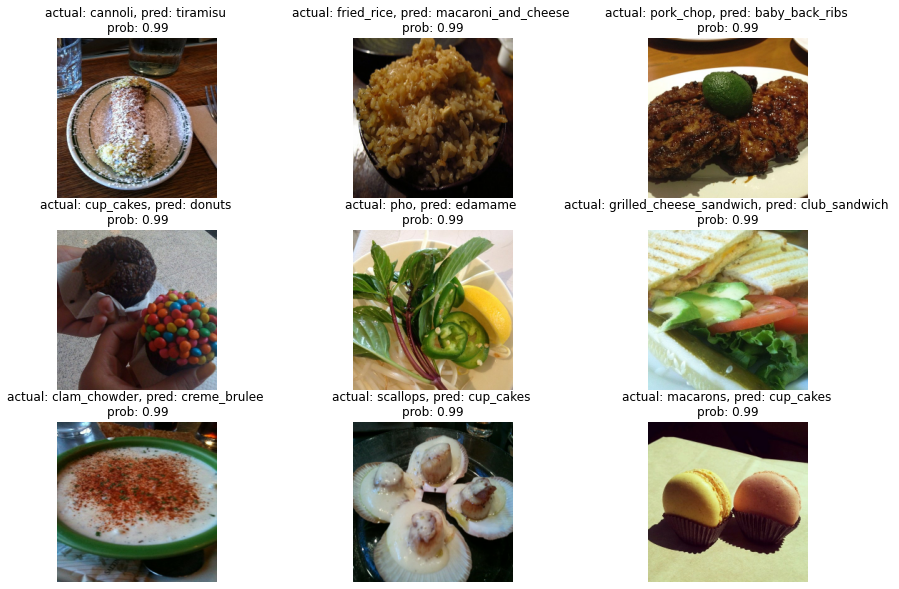

In [ ]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
    plt.subplot(3, 3, i+1)
    img = load_and_prep_image(row[1], scale=True)
    _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
    plt.imshow(img)
    plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
    plt.axis(False)

In [ ]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip") 

--2023-01-25 19:20:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.218.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2023-01-25 19:20:48 (98.3 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/hamburger.jpeg']

1/1 [==============================] - 0s 31ms/step


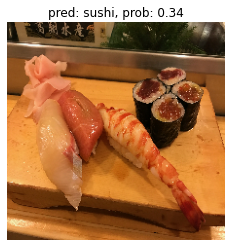

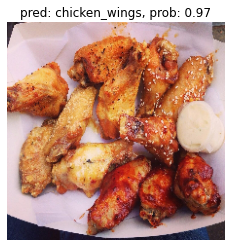

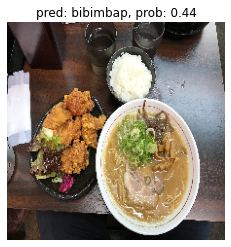

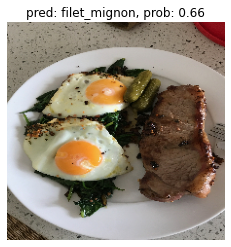

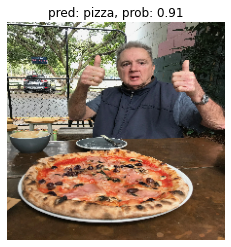

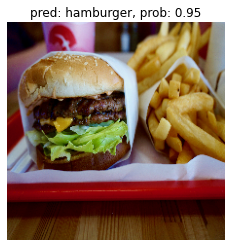

In [ ]:
# Make predictions on custom food images
for img in custom_food_images:
    img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
    pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
    pred_class = class_names[pred_prob.argmax()] # find the predicted class label
    # Plot the image with appropriate annotations
    plt.figure()
    plt.imshow(img/255.) # imshow() requires float inputs to be normalized
    plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
    plt.axis(False)